In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Menginstal pustaka yang dibutuhkan
!pip install torch torchvision torchsummary --quiet

In [2]:
# Import pustaka
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive

In [3]:
# Set device (pastikan menggunakan device yang sama atau sesuai)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Menggunakan device: {device}")


# --- Definisi Model ConvNeXt ---
# Pastikan definisi kelas model ini SAMA PERSIS dengan yang ada di notebook pelatihan Anda
class ConvNextModel(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNextModel, self).__init__()
        # Gunakan ConvNeXt pre-trained sebagai backbone
        self.convnext = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
        # Ganti layer fully connected terakhir
        in_features = self.convnext.classifier[2].in_features
        self.convnext.classifier[2] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.convnext(x)

Menggunakan device: cpu


Model berhasil dimuat dari: /content/drive/MyDrive/Dataset dan Model/convnext_adam_best_model.pth
Ditemukan 11 gambar di folder testing.

Melakukan prediksi pada gambar testing...


Prediksi selesai.

Hasil Prediksi:
Gambar: c1-1.jpg, Prediksi: Tuberculosis, Confidence: 0.9981
Gambar: c0-1.jpg, Prediksi: Normal, Confidence: 0.9963
Gambar: c0-2.jpg, Prediksi: Normal, Confidence: 0.6593
Gambar: c0-3.jpg, Prediksi: Normal, Confidence: 0.9007
Gambar: c0-4.jpeg, Prediksi: Normal, Confidence: 0.8881
Gambar: c1-2.jpg, Prediksi: Tuberculosis, Confidence: 0.9692
Gambar: c1-4.png, Prediksi: Tuberculosis, Confidence: 0.9809
Gambar: c1-6.png, Prediksi: Tuberculosis, Confidence: 0.9979
Gambar: c1-5.png, Prediksi: Tuberculosis, Confidence: 0.9913
Gambar: c0-5.png, Prediksi: Normal, Confidence: 0.9278
Gambar: c1-3.jpg, Prediksi: Tuberculosis, Confidence: 0.7859


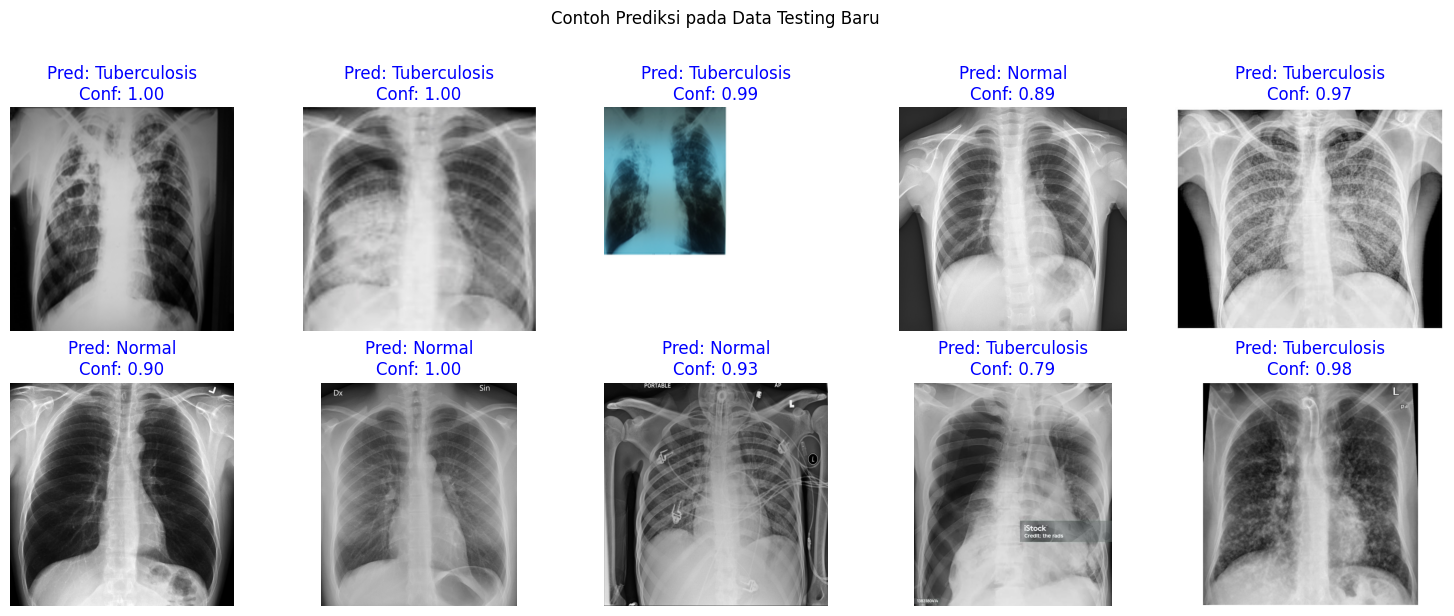

In [7]:
# --- Load Model yang Sudah Dilatih ---
# Path ke file model yang disimpan di Google Drive Anda
model_path = "/content/drive/MyDrive/Dataset dan Model/convnext_adam_best_model.pth" # Ganti dengan path file Anda
num_classes = 2 # Sesuaikan jika jumlah kelas berbeda

# Inisialisasi model
model = ConvNextModel(num_classes=num_classes).to(device)

# Muat state dictionary
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Model berhasil dimuat dari: {model_path}")
except FileNotFoundError:
    print(f"Error: File model tidak ditemukan di {model_path}. Pastikan path-nya benar.")
except Exception as e:
    print(f"Error saat memuat model: {e}")
    # Handle error loading model

model.eval() # Set model ke mode evaluasi

# --- Siapkan Dataset Testing Baru ---
# Path ke folder yang berisi gambar testing Anda (misalnya di Google Drive)
# Jika folder testing ada di luar Drive, Anda perlu mengunggahnya atau menyesuaikannya
test_image_folder = "/content/drive/MyDrive/Dataset dan Model/testing_images"

# Mendapatkan daftar semua file gambar di folder testing
test_image_paths = [os.path.join(test_image_folder, f) for f in os.listdir(test_image_folder)
                    if os.path.isfile(os.path.join(test_image_folder, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if not test_image_paths:
    print(f"Tidak ada gambar ditemukan di folder: {test_image_folder}")
    # Anda bisa keluar atau handle kasus ini

print(f"Ditemukan {len(test_image_paths)} gambar di folder testing.")

# Transformasi untuk gambar testing
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset dan DataLoader sederhana untuk gambar testing
class SimpleTestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_path # Kembalikan gambar dan path-nya

test_dataset = SimpleTestDataset(image_paths=test_image_paths, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# --- Lakukan Prediksi ---
predictions = []
confidences = [] # Untuk menyimpan nilai confidence
image_filenames = []
class_names = ['Normal', 'Tuberculosis']

print("\nMelakukan prediksi pada gambar testing...")
# Membuat progress bar
progress_bar = tqdm(test_loader, total=len(test_loader), desc="Predicting", leave=False)

with torch.no_grad():
    for images, paths in progress_bar:
        images = images.to(device)

        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1) # Hitung probabilitas dengan softmax
        conf, predicted = torch.max(probabilities, 1) # Dapatkan confidence dan kelas prediksi

        predictions.extend(predicted.cpu().numpy())
        confidences.extend(conf.cpu().numpy()) # Simpan nilai confidence
        image_filenames.extend([os.path.basename(p) for p in paths])

print("Prediksi selesai.")

# --- Tampilkan Hasil Prediksi ---
print("\nHasil Prediksi:")
for filename, pred_class_idx, confidence in zip(image_filenames, predictions, confidences):
    predicted_class_name = class_names[pred_class_idx]
    print(f"Gambar: {filename}, Prediksi: {predicted_class_name}, Confidence: {confidence:.4f}") # Tampilkan confidence


# Visualisasikan beberapa prediksi
import random # Impor modul random

def visualize_test_predictions(image_paths, predictions, confidences, num_samples=10): # Tambahkan confidences
    """Visualizes a few test images with their predictions and confidence scores."""
    plt.figure(figsize=(15, 6))
    plt.suptitle("Contoh Prediksi pada Data Testing Baru", y=1.02)

    sampled_indices = random.sample(range(len(image_paths)), min(num_samples, len(image_paths)))

    for i, idx in enumerate(sampled_indices):
        img_path = image_paths[idx]
        pred_class_idx = predictions[idx]
        confidence = confidences[idx] # Ambil confidence
        predicted_class_name = class_names[pred_class_idx]

        img = Image.open(img_path).convert('RGB')

        plt.subplot((num_samples + 4) // 5, 5, i + 1) # Layout grid
        plt.imshow(img)
        plt.title(f"Pred: {predicted_class_name}\nConf: {confidence:.2f}", color='blue') # Tampilkan confidence
        plt.axis('off')

    plt.tight_layout()
    plt.show()


visualize_test_predictions(test_image_paths, predictions, confidences, num_samples=10) # Panggil dengan confidences